In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit as logistic
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['retina']
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 10.1

In [2]:
d = pd.read_csv('Data/chimpanzees.csv', sep=";")
# we change "actor" to zero-index
d.actor = d.actor - 1
d.describe()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
count,504.000000,252.00000,504.000000,504.000000,504.000000,504.000000,504.00000,504.000000
mean,3.000000,5.00000,0.500000,3.500000,36.375000,0.500000,0.56746,0.579365
std,2.001987,2.00398,0.500497,1.709522,20.790832,0.500497,0.49592,0.494151
min,0.000000,2.00000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000
25%,1.000000,3.00000,0.000000,2.000000,18.000000,0.000000,0.00000,0.000000
50%,3.000000,5.00000,0.500000,3.500000,36.000000,0.500000,1.00000,1.000000
75%,5.000000,7.00000,1.000000,5.000000,54.000000,1.000000,1.00000,1.000000
max,6.000000,8.00000,1.000000,6.000000,72.000000,1.000000,1.00000,1.000000


#### Code 10.2

In [3]:
with pm.Model() as model_10_1:
    a = pm.Normal('a', 0, 10)
    p = pm.math.invlogit(a)    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2579.36draws/s]


In [4]:
df_10_1 = pm.summary(trace_10_1, alpha=.11)
df_10_1.round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.32,0.09,0.0,0.17,0.45,855.61,1.0


#### Code 10.3

In [5]:
logistic(df_10_1.iloc[:,3:5]).round(5)

,hpd_5.5,hpd_94.5
a,0.54185,0.61118


#### Code 10.4

In [6]:
with pm.Model() as model_10_2:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    p = pm.math.invlogit(a + bp * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_2 = pm.sample(1000, tune=1000)

with pm.Model() as model_10_3:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bp, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1102.25draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpC, bp, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 780.04draws/s]


#### Code 10.5

In [7]:
comp_df = pm.compare({model_10_1 : trace_10_1,
                      model_10_2 : trace_10_2,
                      model_10_3 : trace_10_3},
                     method='pseudo-BMA')

comp_df.loc[:,'model'] = pd.Series(['m10.1', 'm10.2', 'm10.3'])
comp_df = comp_df.set_index('model')
comp_df

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m10.2,680.45,1.97,0,0.69,9.33,0,0
m10.3,682.19,2.93,1.75,0.29,9.49,0.87,0
m10.1,687.95,1.01,7.51,0.02,7.18,6.21,0


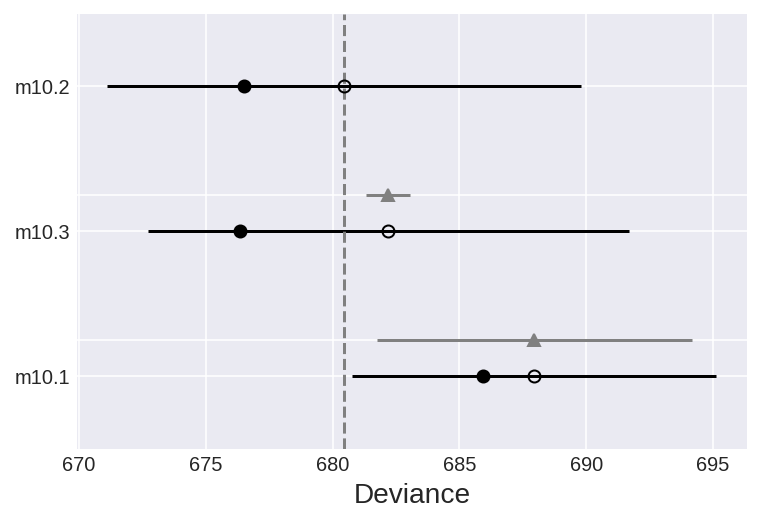

In [8]:
pm.compareplot(comp_df);

#### Code 10.6

It’s not enough to show some other model beats it by WAIC comparison. We also want to understand why m10.3 compares poorly with m10.2 . So let’s look at the estimates for m10.3

In [9]:
pm.summary(trace_10_3, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.05,0.12,0.00,-0.16,0.22,1192.39,1.0
bp,0.62,0.22,0.01,0.30,1.00,1094.70,1.0
bpC,-0.11,0.26,0.01,-0.57,0.28,1408.02,1.0


The estimated interaction effect bpC is negative, with a rather wide posterior on both sides of zero. So regardless of the information theory ranking, the estimates suggest that the chimpanzees did not care much about the other animal’s presence. But they do prefer to pull the prosocial option, as indicated by the estimate for bp.

#### Code 10.7

The customary measure of relative effect for a logistic model is the proportional change in odds. You can compute the proportional odds by merely exponentiating the parameter estimate. Remember, odds are the ratio of the probability an event happens to the probability it does not happen.

In [10]:
np.exp(trace_10_3['bp'].mean())

1.866279214623724

You can read this a proportional increase of 1.82 in the odds of pulling the left-hand lever.
What this means is that the odds increase by 82%.

#### Code 10.8

The major difficulty with the proportional odds is that the actual change in probability will also depend upon the intercept, α, as well as any other predictor variables. Remember, GLMs like this logistic regression induce interactions among all variables. In this case, you can think of these interactions as resulting from both ceiling and floor effects: If the intercept is large enough to guarantee a pull, then increasing the odds by 82% isn’t going to make it any more guaranteed. For example, suppose α were estimated to have a value of 4. Then the
probability of a pull, ignoring everything else, would be:

In [11]:
logistic(4)

0.9820137900379085

#### Code 10.9

Adding in an increase because of the estimate for bp changes this to:

In [12]:
logistic(4 + trace_10_3['bp'].mean())

0.9902813918574606

So that’s a difference, on the absolute scale, of less than 1%, despite being an 84% increase in proportional odds. Likewise, if the intercept is very negative, then the probability of a pull is almost zero. An increase in odds of 82% may not be enough to get the probability up off the floor. Relative effects, as measured by proportional odds or anything else, can be misleading. It’s always wise to simultaneously consider absolute effects, the prediction scale.

#### Code 10.10 and 10.11

In [13]:
d_pred = pd.DataFrame({'prosoc_left' : [0, 1, 0, 1], 'condition' : [0, 0, 1, 1]})
traces = [trace_10_1, trace_10_2, trace_10_3]
models = [model_10_1, model_10_2, model_10_3]


chimp_ensemble = pm.sample_ppc_w(traces=traces, models=models, samples=1000, 
                                 weights=comp_df.weight.sort_index(ascending=True))

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive_w()
  import sys
100%|██████████| 1000/1000 [00:00<00:00, 1278.99it/s]


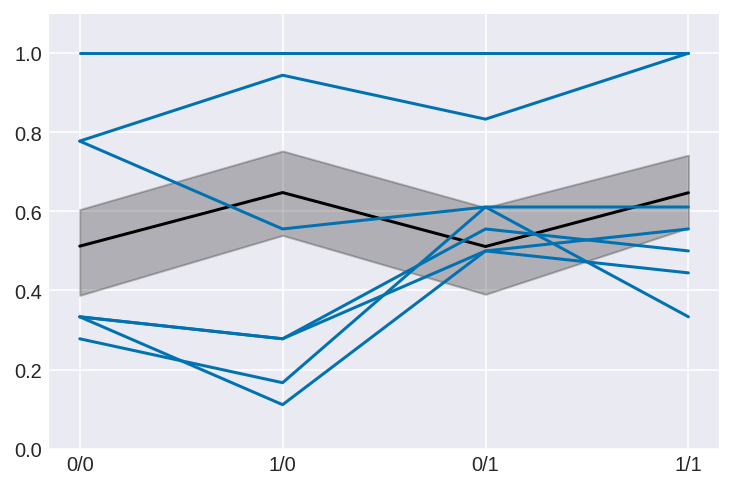

In [14]:
# predictions of WAIC-weighted model 
rt = chimp_ensemble['pulled_left']
pred_mean = np.zeros((1000, 4))
# possible values for condition
cond = d.condition.unique()
# possible values for prosocial choice
prosoc_l = d.prosoc_left.unique()
# for every prediction sample
for i in range(len(rt)):
    tmp = []
    if rt[i].size < 2:
        continue
    # for every possible combination of choices
    for cp in cond:
        for pl in prosoc_l:
            # mean of times a chimp pulled left under different combinations of 
            # cp and pl (the predictor variables)
            tmp.append(np.mean(rt[i][(d.prosoc_left==pl) & (d.chose_prosoc==cp)]))
    # store result
    pred_mean[i] = tmp
    
ticks = range(4)
# plot mean probability of pulling left for each combination of predictors
mp = pred_mean.mean(0)
hpd = pm.hpd(pred_mean)
plt.fill_between(ticks, hpd[:,1], hpd[:,0], alpha=0.25, color='k')
plt.plot(mp, color='k')
plt.xticks(ticks, ("0/0","1/0","0/1","1/1"))
# get mean probs for pulled left from data for each chimp and every combination of predictors
# see `d.groupby(['actor', 'prosoc_left', 'condition']).agg('mean')['pulled_left']`
chimps = d.groupby(['actor', 'prosoc_left', 'condition']).agg('mean')['pulled_left'].values.reshape(7, -1)
for i in range(7):
    plt.plot(chimps[i], 'C0')

plt.ylim(0, 1.1);

The model did what we asked it to do:
Estimate the average across all chimpanzees. But there is a lot of variation among individuals in the blue lines in the figure above. In principle, individual variation could mask the association of interest. That isn’t much of a risk here four individuals show the same zig-zag pattern as the prediction, just offset towards the right-hand lever. The other three prefer the left lever overall, but only one of them actually pulls the left lever more when both the prosocial option is on the left and a partner is present. Still, it’ll be useful to see how to model the individual variation, even if it isn’t going to change the effective inference in this context.

#### Code 10.12 & 10.13
This is the same as 10.6, but in the book using MCMC rather than quadratic approximation.

#### Code 10.14

In [15]:
with pm.Model() as model_10_4:
    # note we define a vector of intercepts, for each actor
    a = pm.Normal('alpha', 0, 10, shape=len(d.actor.unique()))
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    # model intercept of different actors differently
    p = pm.math.invlogit(a[d.actor.values] + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpC, bp, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:10<00:00, 392.61draws/s]
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


#### Code 10.15

In [16]:
# remember we use a zero-index
d['actor'].unique()

array([0, 1, 2, 3, 4, 5, 6])

#### Code 10.16

In [17]:
pm.summary(trace_10_4, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha__0,-0.73,0.27,0.01,-1.15,-0.30,1420.60,1.0
alpha__1,11.11,5.49,0.18,3.66,18.89,811.36,1.0
alpha__2,-1.04,0.28,0.01,-1.46,-0.57,1598.79,1.0
alpha__3,-1.05,0.27,0.01,-1.50,-0.62,1224.61,1.0
alpha__4,-0.73,0.27,0.01,-1.11,-0.26,1594.56,1.0
alpha__5,0.21,0.27,0.01,-0.21,0.65,1421.07,1.0
alpha__6,1.78,0.39,0.01,1.16,2.37,1403.82,1.0
bp,0.84,0.26,0.01,0.45,1.25,779.65,1.0
bpC,-0.14,0.30,0.01,-0.58,0.35,953.40,1.0


#### Code 10.17

In [18]:
post = pm.trace_to_dataframe(trace_10_4)
post.head()

,alpha__0,alpha__1,alpha__2,alpha__3,alpha__4,alpha__5,alpha__6,bp,bpC
0,-0.814874,5.507143,-1.134681,-1.041259,-0.812676,0.174495,0.988329,1.073278,-0.286506
1,-0.814874,5.507143,-1.134681,-1.041259,-0.812676,0.174495,0.988329,1.073278,-0.286506
2,-0.814874,5.507143,-1.134681,-1.041259,-0.812676,0.174495,0.988329,1.073278,-0.286506
3,-0.820944,7.910014,-1.052381,-1.060007,-0.710703,0.238832,1.200500,1.227236,-0.226361
4,-0.529816,6.458074,-1.020194,-0.964268,-0.447655,0.221199,1.568702,1.067054,-0.992548


#### Code 10.18

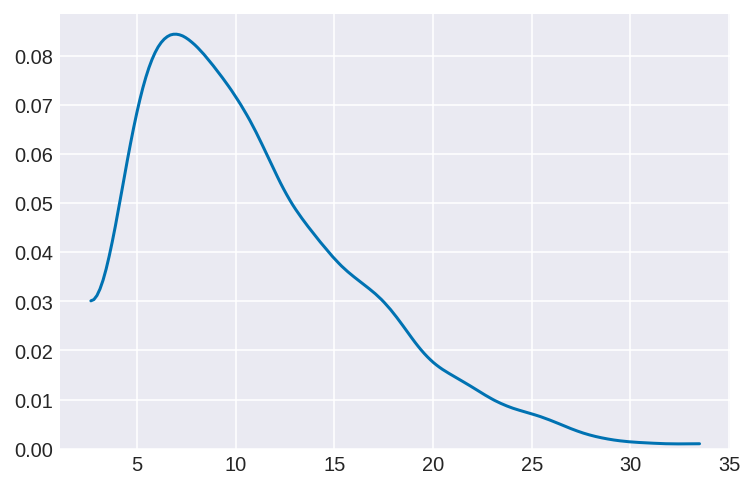

In [19]:
pm.kdeplot(post['alpha__1']);

Marginal posterior density of alpha_1 , the intercept for actor number 2. Very many very large values are plausible. Since actor number 2 always pulled the left-hand lever, the data cannot discriminate among these large values, as all of them guarantee pulling the left-hand lever.

#### Code 10.19

In [20]:
rt = pm.sample_ppc(trace_10_4, 1000, model_10_4)['pulled_left']
rt.shape

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 1000/1000 [00:01<00:00, 940.28it/s]


(1000, 504)

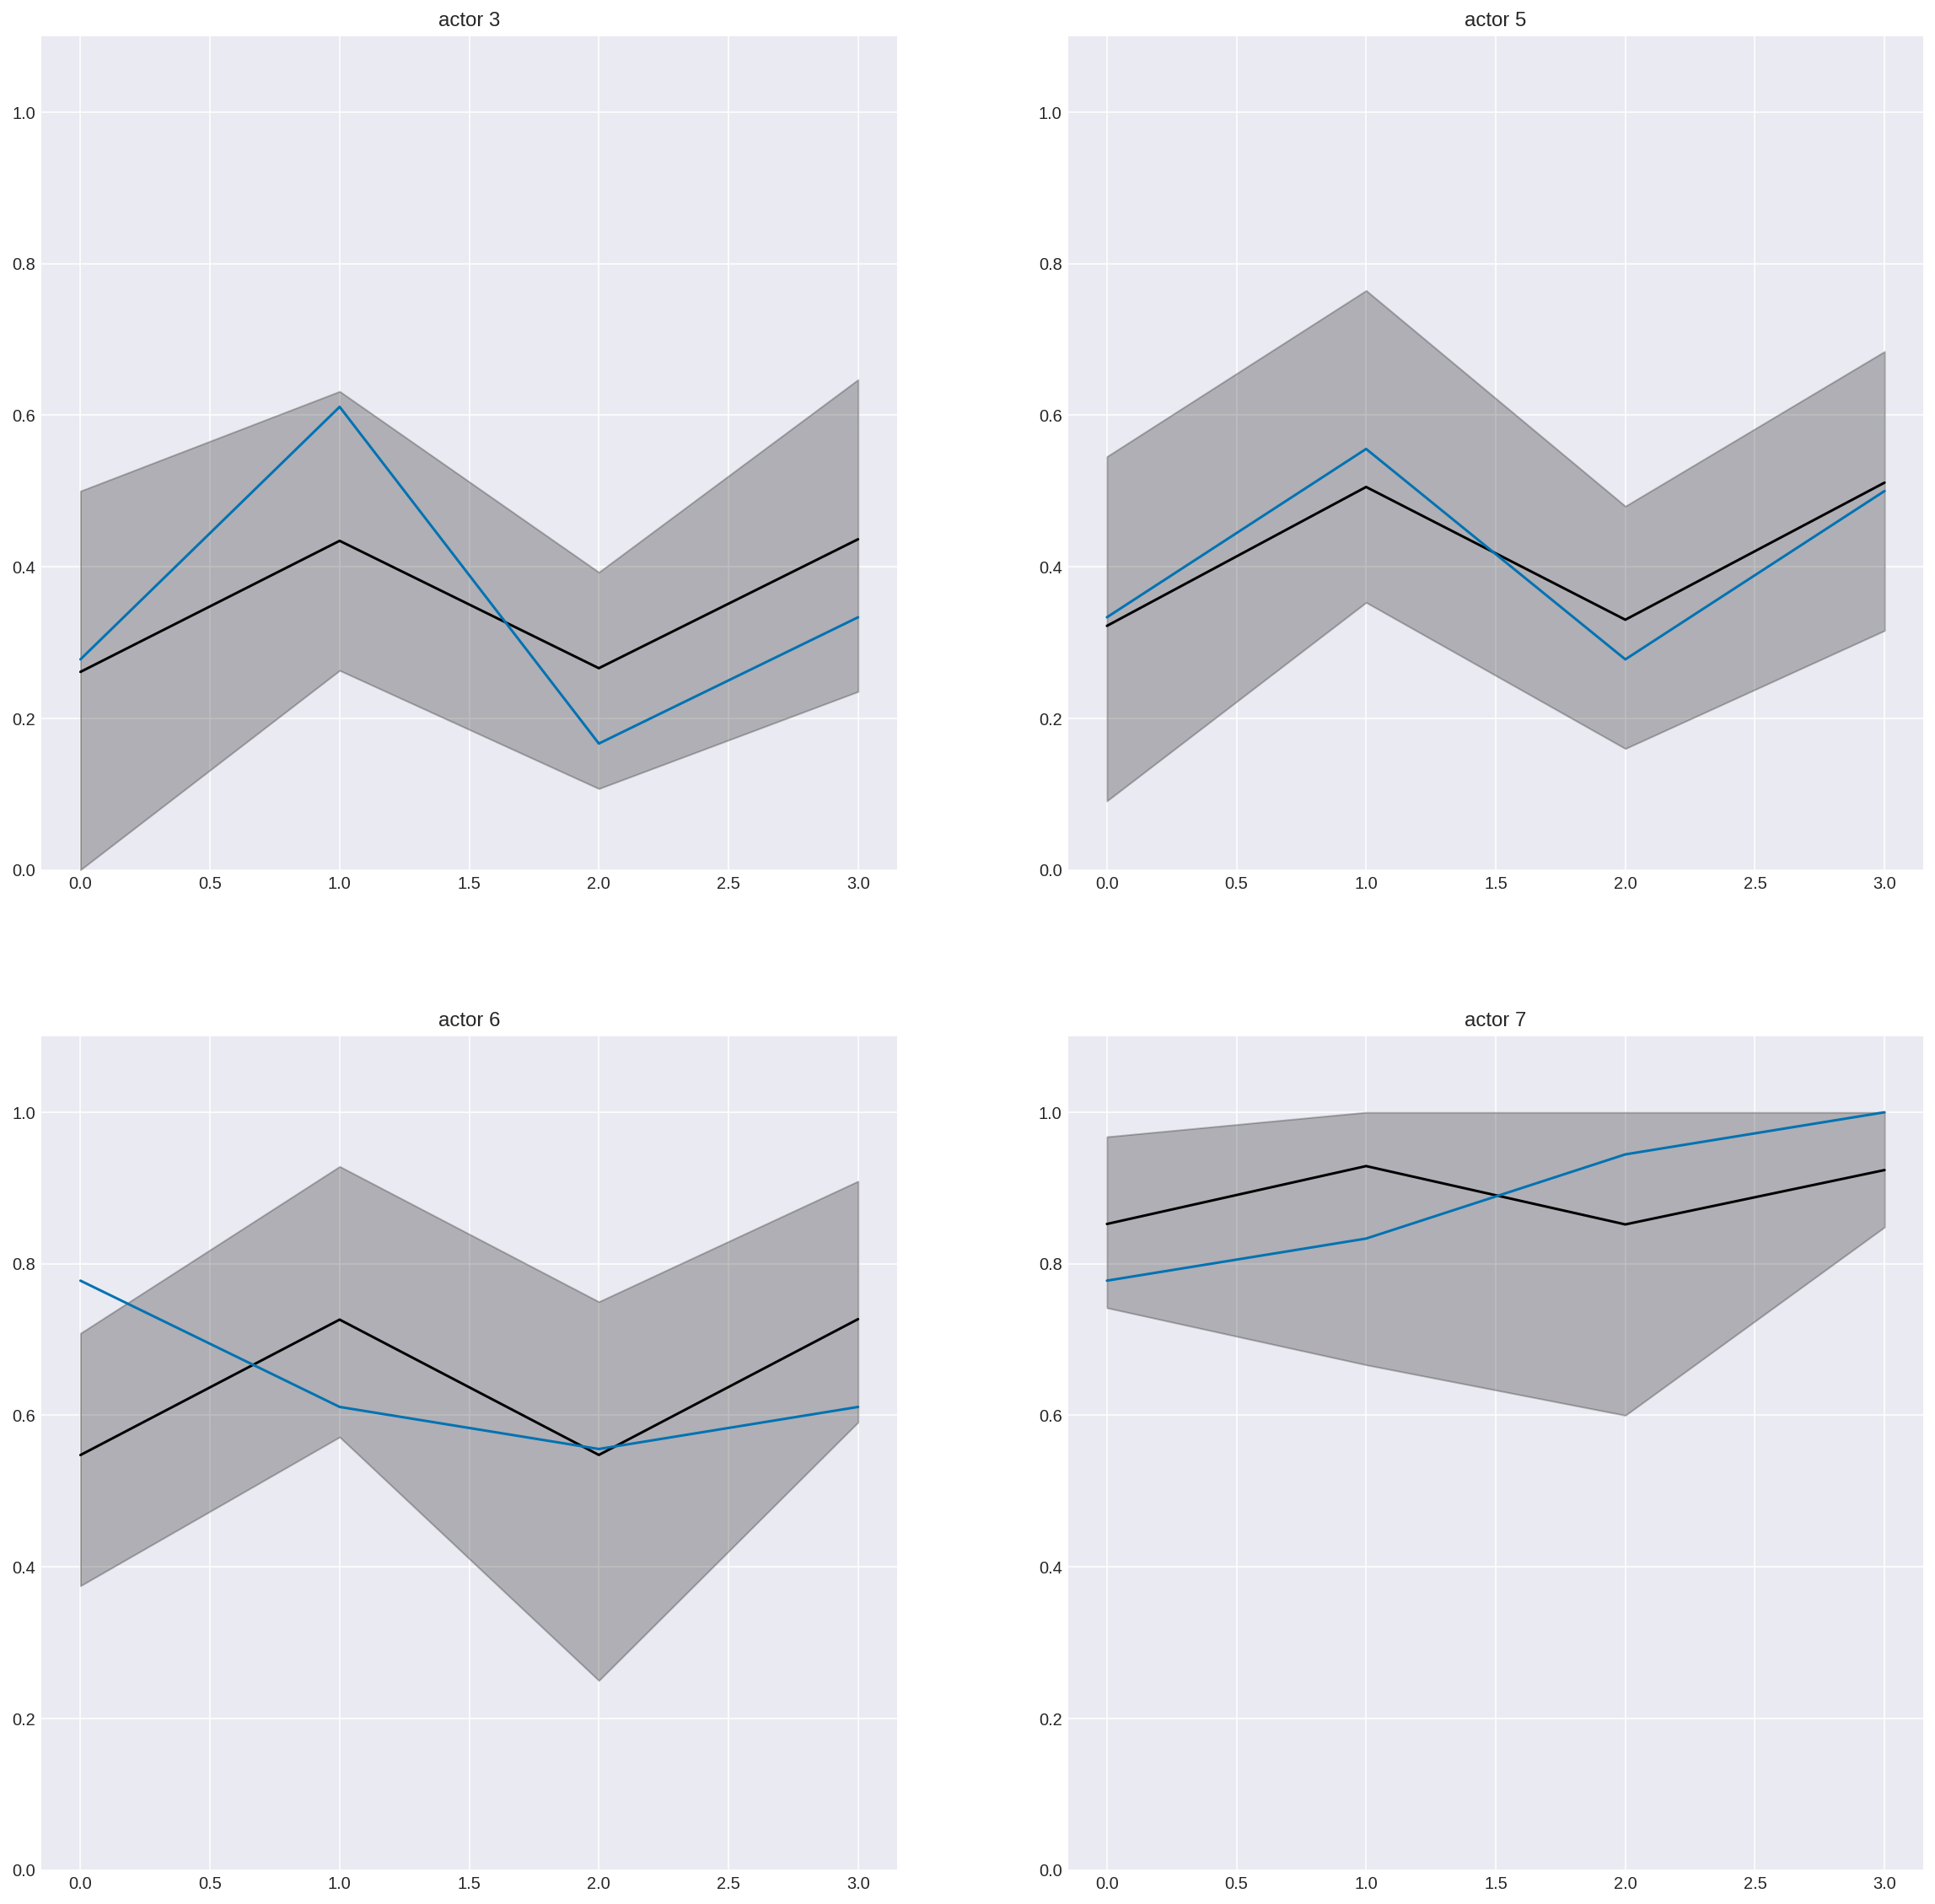

In [21]:
chimp_list = [2, 4, 5, 6]
fig, axs = plt.subplots(2,2, figsize=(20,20))
for chimp, ax in zip(chimp_list, axs.ravel()):
    pred_mean = np.zeros((1000, 4))
    cond = d.condition.unique()
    prosoc_l = d.prosoc_left.unique()
    for i in range(len(rt)):
        tmp = []
        for cp in cond:
            for pl in prosoc_l:
                # average prediction of pulling left for a specific combination of predictors AND
                # a specified chimp
                tmp.append(np.mean(rt[i][(d.prosoc_left == pl) & (d.chose_prosoc == cp) & (d.actor == chimp)]))
        pred_mean[i] = tmp

    ticks = range(4)
    mp = pred_mean.mean(0)
    hpd = pm.hpd(pred_mean, alpha=0.11)
    ax.fill_between(ticks, hpd[:,1], hpd[:,0], alpha=0.25, color='k')
    ax.plot(mp, color='k')
    ax.set_xticks(ticks, ("0/0","1/0","0/1","1/1"))
    chimps = d[d.actor == chimp].groupby(['condition', 'prosoc_left', ]).agg('mean')['pulled_left'].values
    ax.plot(chimps, 'C0')

    ax.set_ylim(0, 1.1);
    ax.set_title('actor {}'.format(chimp+1))

Actors 3, 5, 6, and 7 are shown. Notice that these individual intercepts do help the model fit the overall level for each chimpanzee. But they do not change the basic zig-zag prediction pattern across treatments.

#### Code 10.20

In [22]:
d_aggregated = d.groupby(['actor', 'condition', 'prosoc_left',  ])['pulled_left'].sum().reset_index()
d_aggregated.head(8)

,actor,condition,prosoc_left,pulled_left
0,0,0,0,6
1,0,0,1,9
2,0,1,0,5
3,0,1,1,10
4,1,0,0,18
5,1,0,1,18
6,1,1,0,18
7,1,1,1,18


#### Code 10.21

In [23]:
with pm.Model() as model_10_5:
    a = pm.Normal('alpha', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a + (bp + bpC * d_aggregated.condition) * d_aggregated.prosoc_left)
    # notice the binomial distribution now has 18 trials instead of 1 (i.e. Bernouli)
    pulled_left = pm.Binomial('pulled_left', 18, p, observed=d_aggregated.pulled_left)

    trace_10_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpC, bp, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1227.04draws/s]


In [24]:
pm.summary(trace_10_5, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,0.05,0.12,0.00,-0.16,0.23,1316.78,1.0
bp,0.62,0.23,0.01,0.28,1.01,1176.40,1.0
bpC,-0.12,0.27,0.01,-0.56,0.30,1248.89,1.0


same results as with the previous model with ntrials=1 (i.e. Bernouli)

In [25]:
pm.summary(trace_10_3, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.05,0.12,0.00,-0.16,0.22,1192.39,1.0
bp,0.62,0.22,0.01,0.30,1.00,1094.70,1.0
bpC,-0.11,0.26,0.01,-0.57,0.28,1408.02,1.0


#### Code 10.22

Often the number of trials on each row is not a constant. So then in place of the “ 18 ” we insert a variable from the data.

In [26]:
d_ad = pd.read_csv('./Data/UCBadmit.csv', sep=';')
d_ad.head(8)

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375


#### Code 10.23

Our job is to evaluate whether these data contain evidence of gender bias in admissions.
We will model the admission decisions, focusing on applicant gender as a predictor variable. So we want to fit at least two models:

In [27]:
d_ad['male'] = (d_ad['applicant.gender'] == 'male').astype(int)

with pm.Model() as model_10_6:
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 10)
    p = pm.math.invlogit(a + bm * d_ad.male)
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_10_6 = pm.sample(1000, tune=1000)
    
with pm.Model() as model_10_7:
    a = pm.Normal('a', 0, 10)
    p = pm.math.invlogit(a)
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_10_7 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bm, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1151.59draws/s]
The acceptance probability does not match the target. It is 0.881222616850294, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2308.47draws/s]
The acceptance probability does not match the target. It is 0.8843415289233798, but should be close to 0.8. Try to increase the number of tuning steps.


#### Code 10.24

In [28]:
# WAIC values still off see https://github.com/pymc-devs/resources/issues/9
# and https://discourse.mc-stan.org/t/trying-to-find-waic-for-a-simple-model-from-statistical-rethinking/3991/5
comp_df = pm.compare({model_10_6 : trace_10_6,
                      model_10_7 : trace_10_7}, method = 'pseudo-BMA')

comp_df.loc[:,'model'] = pd.Series(['m10.6', 'm10.7'])
comp_df = comp_df.set_index('model')
comp_df

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/damiano

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m10.6,994.29,109.44,0,1,316.26,0,1
m10.7,1050.62,83.83,56.34,0,315.51,158.3,1


This comparison suggests that gender matters a lot.

#### Code 10.25

In [29]:
pm.summary(trace_10_7, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-0.46,0.03,0.0,-0.51,-0.41,876.17,1.0


In [30]:
pm.summary(trace_10_6, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-0.83,0.05,0.0,-0.90,-0.75,546.66,1.0
bm,0.61,0.06,0.0,0.51,0.70,600.43,1.0


Seems like being male is an advantage in this context. You can compute the relative difference in admission odds as exp(0.61) ≈ 1.84.

#### Code 10.26

In [31]:
post = pm.trace_to_dataframe(trace_10_6)
p_admit_male = logistic(post['a'] + post['bm'])
p_admit_female = logistic(post['a'])
diff_admit = p_admit_male - p_admit_female
diff_admit.describe(percentiles=[.025, .5, .975])[['2.5%', '50%', '97.5%']]

2.5%     0.112625
50%      0.141002
97.5%    0.168614
dtype: float64

This means that the median estimate of the male advantage is about 14%, with a 95% interval from 11% to almost 17%.

#### Code 10.27

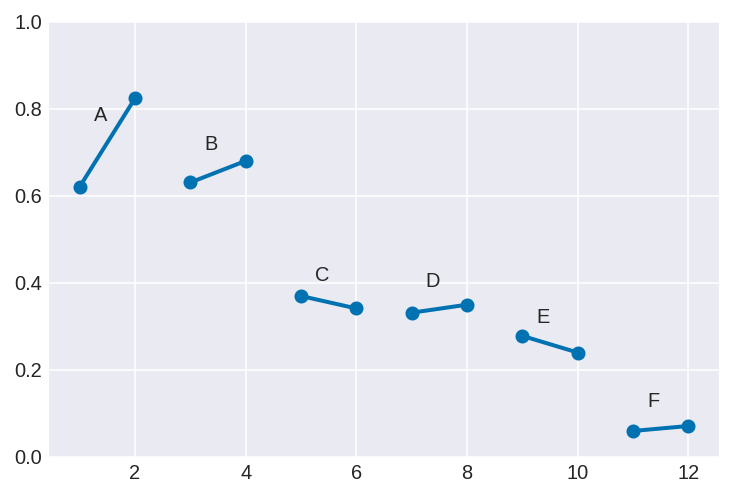

In [32]:
for i in range(6):
    x = 1 + 2 * i
    y1 = d_ad.admit[x] / d_ad.applications[x]
    y2 = d_ad.admit[x+1] / d_ad.applications[x+1]
    plt.plot([x, x+1], [y1, y2], '-C0o', lw=2)
    plt.text(x + 0.25, (y1+y2)/2 + 0.05, d_ad.dept[x])
plt.ylim(0, 1);

The model did correctly answer the question we asked of it: What are the average probabilities of admission for females and males, across all departments? The problem in this case is that males and females do not apply to the same departments, and departments vary in their rates of admission. This makes the answer misleading. You can see the steady decline in admission probability for both males and females from department A to department F. 

Females in these data tended not to apply to departments like A and B, which had high overall admission rates.
Instead they applied in large numbers to departments like F, which admitted less than 10% of applicants. So while it is true overall that females had a lower probability of admission in these data, it is clearly not true within most departments. And note that just inspecting the posterior distribution alone would never have revealed that fact to us. We had to appeal to something outside the fit model. In this case, it was a simple posterior validation check. 

#### Code 10.28

In [33]:
d_ad['dept_id'] = pd.Categorical(d_ad['dept']).codes

In [34]:
with pm.Model() as model_10_8:
    a = pm.Normal('a', 0, 10, shape=len(d_ad['dept'].unique()))
    p = pm.math.invlogit(a[d_ad['dept_id'].values])
    admit = pm.Binomial('admit', p=p, n=d_ad['applications'], observed=d_ad['admit'])
    
    trace_10_8 = pm.sample(1000, tune=1000)

with pm.Model() as model_10_9:
    a = pm.Normal('a', 0, 10, shape=len(d_ad['dept'].unique()))
    bm = pm.Normal('bm', 0, 10)
    p = pm.math.invlogit(a[d_ad['dept_id'].values] + bm * d_ad['male'])
    admit = pm.Binomial('admit', p=p, n=d_ad['applications'], observed=d_ad['admit'])
    
    trace_10_9 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1612.22draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bm, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 748.64draws/s]


#### Code 10.29

In [35]:
# WAIC values still off see https://github.com/pymc-devs/resources/issues/9
# and https://discourse.mc-stan.org/t/trying-to-find-waic-for-a-simple-model-from-statistical-rethinking/3991/5
comp_df = pm.compare({model_10_6 : trace_10_6,
                      model_10_7 : trace_10_7,
                      model_10_8 : trace_10_8,
                      model_10_9 : trace_10_9},
                     method='pseudo-BMA')

comp_df.loc[:,'model'] = pd.Series(['m10.6', 'm10.7', 'm10.8', 'm10.9'])
comp_df = comp_df.set_index('model')
comp_df

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/damiano

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m10.8,105.63,6.82,0,0.83,17.32,0,1
m10.9,108.85,9.52,3.22,0.17,15.65,3.68,1
m10.6,994.29,109.44,888.66,0,316.26,313.2,1
m10.7,1050.62,83.83,945,0,315.51,312.98,1


#### Code 10.30

In [36]:
pm.summary(trace_10_9, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a__0,0.68,0.10,0.0,0.51,0.83,1387.30,1.0
a__1,0.64,0.12,0.0,0.46,0.82,1465.04,1.0
a__2,-0.58,0.08,0.0,-0.71,-0.47,2238.70,1.0
a__3,-0.61,0.09,0.0,-0.75,-0.48,1965.66,1.0
a__4,-1.06,0.10,0.0,-1.22,-0.90,2534.91,1.0
a__5,-2.63,0.16,0.0,-2.89,-2.38,2141.89,1.0
bm,-0.10,0.08,0.0,-0.22,0.03,1161.95,1.0


#### Code 10.31
Replicated model above but with MCMC in book.

#### Code 10.32

In [37]:
import statsmodels.api as sm
from patsy import dmatrix

endog = d_ad.loc[:,['admit', 'reject']].values # cbind(admit,reject)

m10_7glm = sm.GLM(endog, dmatrix('~ 1', data=d_ad), 
                  family=sm.families.Binomial())
m10_6glm = sm.GLM(endog, dmatrix('~ male', data=d_ad), 
                  family=sm.families.Binomial())
m10_8glm = sm.GLM(endog, dmatrix('~ dept_id', data=d_ad), 
                  family=sm.families.Binomial())
m10_9glm = sm.GLM(endog, dmatrix('~ male + dept_id', data=d_ad), 
                  family=sm.families.Binomial())
print('********************************************************************************')
res = m10_7glm.fit()
print(res.summary())
print('>>>>>>>>>>> pymc3 results <<<<<<<<<<<<')
print(pm.summary(trace_10_7).round(2))
print('********************************************************************************')
res = m10_6glm.fit()
print(res.summary())
print('>>>>>>>>>>> pymc3 results <<<<<<<<<<<<')
print(pm.summary(trace_10_6).round(2))
# these below are not comparable since they need to add mixed effects to statsmodels glm
# print('********************************************************************************')
# res = m10_8glm.fit()
# print(res.summary())
# print('>>>>>>>>>>> pymc3 results <<<<<<<<<<<<')
# print(pm.summary(trace_10_8).round(2))
# print('********************************************************************************')
# res = m10_9glm.fit()
# print(res.summary())
# print('>>>>>>>>>>> pymc3 results <<<<<<<<<<<<')
# print(pm.summary(trace_10_9).round(2))

********************************************************************************
                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                   12
Model:                            GLM   Df Residuals:                       11
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -473.00
Date:                Tue, 16 Jul 2019   Deviance:                       877.06
Time:                        15:36:46   Pearson chi2:                     798.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

#### Code 10.33

In [38]:
import statsmodels.formula.api as smf
m10_4glm = smf.glm(formula='pulled_left ~ actor + prosoc_left*condition - condition', data=d, 
                   family=sm.families.Binomial())
res = m10_4glm.fit()
print(res.summary())
print('>>>>>>>>>>> pymc3 results <<<<<<<<<<<<')
print(pm.summary(trace_10_4).round(2))
# above not comparable since actor needs to be added a mixed effect and not as categorical

                 Generalized Linear Model Regression Results                  
Dep. Variable:            pulled_left   No. Observations:                  504
Model:                            GLM   Df Residuals:                      500
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -335.02
Date:                Tue, 16 Jul 2019   Deviance:                       670.04
Time:                        15:36:46   Pearson chi2:                     504.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.29

#### Code 10.34

In [39]:
pm.GLM.from_formula('pulled_left ~ actor + prosoc_left*condition - condition', 
                    family='binomial', data=d)   

#### Code 10.35

In [40]:
# outcome and predictor almost perfectly associated
y = np.hstack([np.ones(10,)*0, np.ones(10,)])
x = np.hstack([np.ones(9,)*-1, np.ones(11,)])

m_bad = smf.glm(formula='y ~ x', 
                data=pd.DataFrame({'y':y, 'x':x}), 
                family=sm.families.Binomial()).fit()
m_bad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:                            GLM   Df Residuals:                       18
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3.3510
Date:                Tue, 16 Jul 2019   Deviance:                       6.7020
Time:                        15:36:46   Pearson chi2:                     11.0
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.1317   8032.690     -0.001      0.999   -1.58e+04    1.57e+04
x             12.4343   8032.690      0.002      0.999   -1.57e+04    1.58e+04
==============================================================================
"""

#### Code 10.36

In [41]:
with pm.Model() as m_good:
    ab = pm.Normal('ab', 0, 10, shape=2)
    p = pm.math.invlogit(ab[0] + ab[1]*x)
    y_ = pm.Binomial('y_', 1, p, observed=y)
    
    MAP = pm.find_MAP()
MAP

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -9.9185, ||grad|| = 7.2889e-05: 100%|██████████| 13/13 [00:00<00:00, 1677.00it/s]  


{'ab': array([-1.72704484,  4.01710522])}

#### Code 10.37

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ab]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1026.55draws/s]
The acceptance probability does not match the target. It is 0.8804742976653515, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


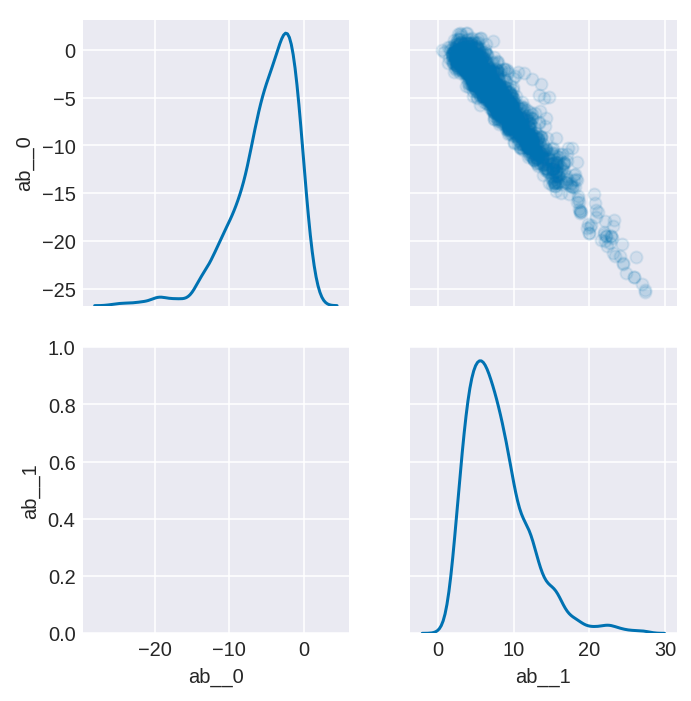

In [42]:
trace = pm.sample(1000, tune=1000, model=m_good)
tracedf = pm.trace_to_dataframe(trace)
grid = (sns.PairGrid(tracedf,
                     diag_sharey=False)
           .map_diag(sns.kdeplot)
           .map_upper(plt.scatter, alpha=0.1))

#### Code 10.38

In [43]:
# binomial ~ poisson as p<< and n>>
y = stats.binom.rvs(n=1000, p=1/1000, size=100000)
np.mean(y), np.var(y)

(0.99539, 0.9920087479000002)

#### Code 10.39

In [44]:
dk = pd.read_csv('Data/Kline', sep=';')
dk

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


#### Code 10.40

In [45]:
dk = dk.assign(log_pop=np.log(dk.population), contact_high=(dk.contact == "high").astype(int))

In [46]:
from theano import shared
# casting data to theano shared variable. 
# It is for out of sample prediction from model with sampled trace
log_pop = shared(dk.log_pop.values)
contact_high = shared(dk.contact_high.values)
total_tools = shared(dk.total_tools.values)

#### Code 10.41

In [47]:
with pm.Model() as m_10_10:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1, shape=3)
    lam = pm.math.exp(a + b[0] * log_pop + b[1] * contact_high + b[2] * contact_high * log_pop)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_10 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:15<00:00, 266.36draws/s]


#### Code 10.42

In [48]:
summary = pm.summary(trace_10_10, alpha=.11)[['mean', 'sd', 'hpd_5.5', 'hpd_94.5']]
trace_cov = pm.trace_cov(trace_10_10, model=m_10_10)
invD = (np.sqrt(np.diag(trace_cov))**-1)[:, None]
trace_corr = pd.DataFrame(invD*trace_cov*invD.T, index=summary.index, columns=summary.index)

summary.join(trace_corr).round(2)

,mean,sd,hpd_5.5,hpd_94.5,a,b__0,b__1,b__2
a,0.95,0.36,0.36,1.52,1.00,-0.97,-0.14,0.09
b__0,0.26,0.03,0.21,0.32,-0.97,1.00,0.14,-0.10
b__1,-0.13,0.86,-1.42,1.24,-0.14,0.14,1.00,-0.99
b__2,0.05,0.09,-0.10,0.19,0.09,-0.10,-0.99,1.00


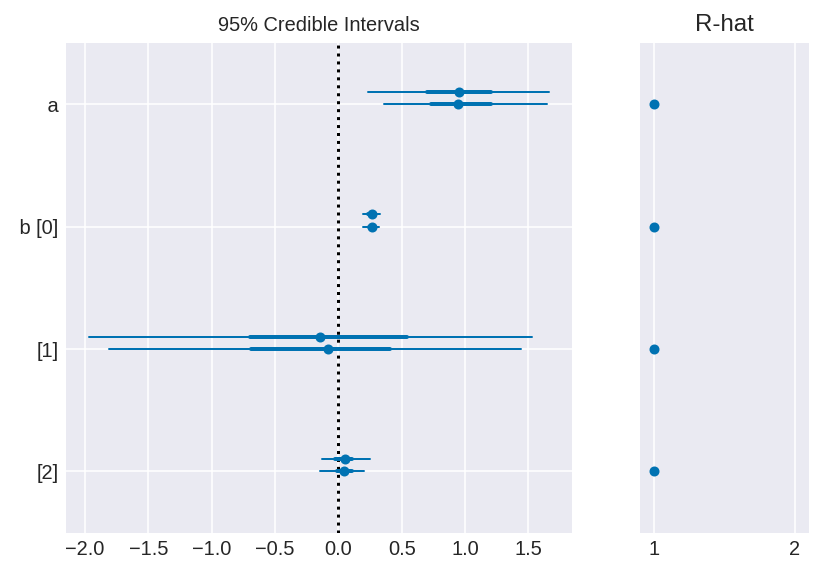

In [49]:
pm.forestplot(trace_10_10);

notice that the main effect of log-population, bp , is positive and precise, but that both bc and bpc overlap zero substantially. So you might think it’s safe to say that log-population is reliably associated with the total tools, but that contact rate has no impact on prediction in this model.

You might think that, but you’d be wrong. As always, it’s very easy to be mislead by tables of estimates, especially when an interaction is involved. To prove that contact rate is having an important effect on prediction in this model, let’s just compute some counterfactual predictions. 

#### Code 10.43

Consider two islands, both with log-population of 8, but one with high contact and the other with low. Let’s calculate λ, the expected tool count, for each. This is accomplished just by drawing samples from the posterior, plugging those samples into the linear model, and then inverting the link function to get back to the scale of the outcome variable. In this case, inverting the link means exponentiating with exp

In [50]:
lambda_high = np.exp(trace_10_10['a'] + trace_10_10['b'][:,1] + (trace_10_10['b'][:,0] + trace_10_10['b'][:,2]) * 8)
lambda_low = np.exp(trace_10_10['a'] + trace_10_10['b'][:,0] * 8 )

#### Code 10.44

In [51]:
diff = lambda_high - lambda_low
np.sum(diff > 0) / len(diff)

0.948

That’s a 95% plausibility that the high-contact island has more tools than the low-contact islands.

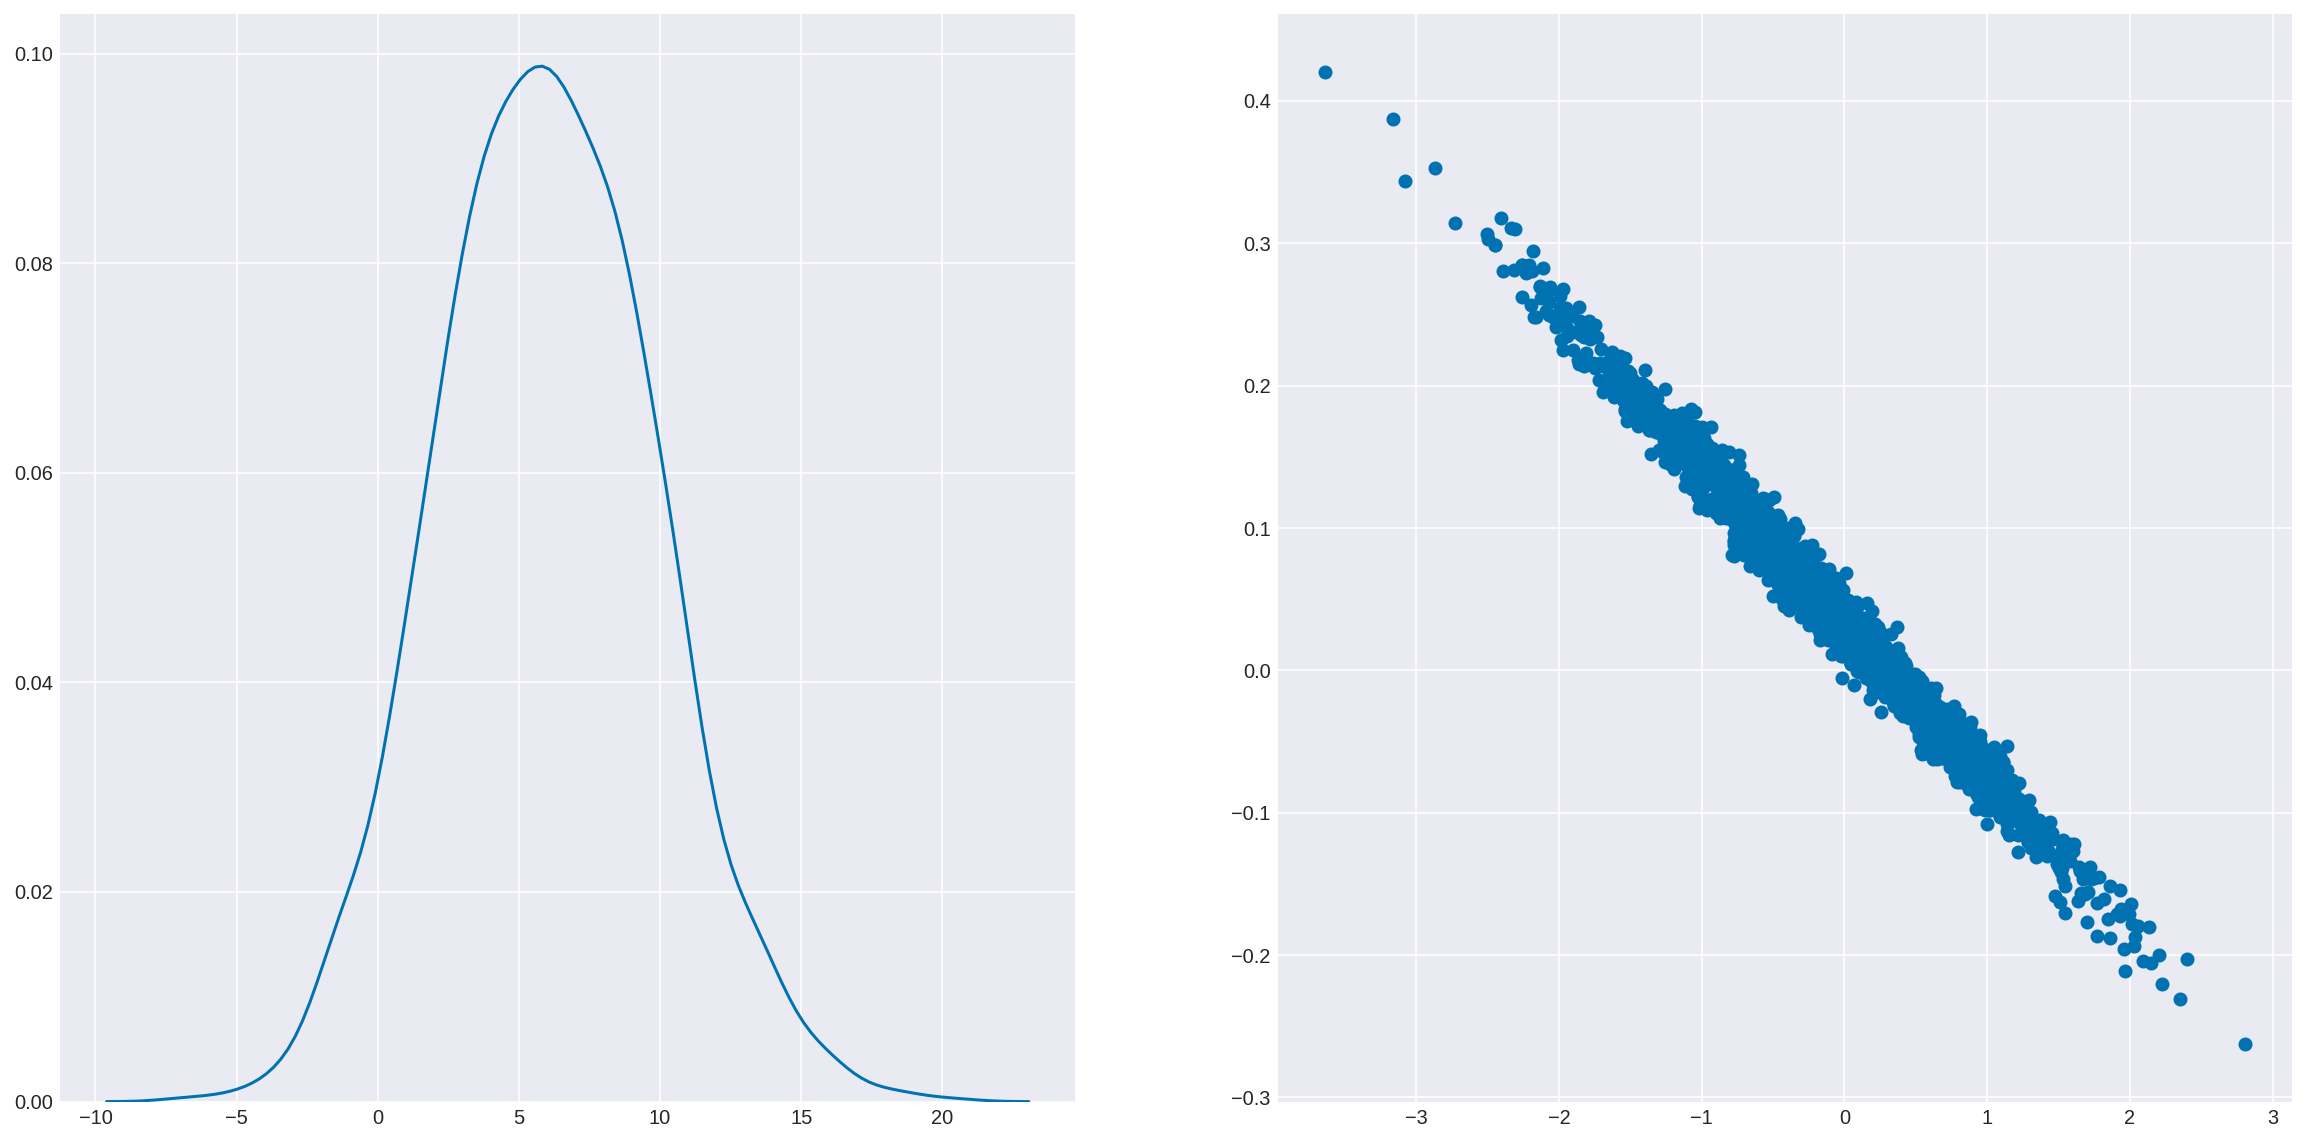

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
sns.kdeplot(diff, ax=ax1);
ax2.scatter(trace_10_10['b'][:,1],trace_10_10['b'][:,2]);

The correlation between bc and bpc is strongly negative, as seen in the right-hand plot. So when bc is small, bpc is large. As a result, you can’t just inspect the marginal uncertainty in each parameter, which is what is shown in the table of estimates, and get an accurate understanding of the impact of the joint uncertainty on prediction.

#### Code 10.45

In [53]:
with pm.Model() as m_10_11:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1, shape=2)
    lam = pm.math.exp(a + b[0] * log_pop + b[1] * contact_high)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_11 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:08<00:00, 457.75draws/s]


#### Code 10.46

In [54]:
with pm.Model() as m_10_12:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1)
    lam = pm.math.exp(a + b * log_pop)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_12 = pm.sample(1000, tune=1000)
    
with pm.Model() as m_10_13:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1)
    lam = pm.math.exp(a + b * contact_high)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_13 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 606.69draws/s]
The acceptance probability does not match the target. It is 0.8826418405025648, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1012.96draws/s]




#### Code 10.47

In [55]:
with pm.Model() as m_10_14:
    a = pm.Normal('a', 0, 100)
    lam = pm.math.exp(a)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_14 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1589.24draws/s]


In [56]:
traces = [trace_10_10, trace_10_11, trace_10_12, trace_10_13, trace_10_14]
models = [m_10_10, m_10_11, m_10_12, m_10_13, m_10_14]

dictionary = dict(zip(models, traces))

islands_compare = pm.compare(dictionary, method='pseudo-BMA')

islands_compare.loc[:,'model'] = pd.Series(['m10.10', 'm10.11', 'm10.12', 'm10.13', 'm10.14'])
islands_compare = islands_compare.set_index('model')
islands_compare

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/damiano

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m10.11,78.52,3.96,0,0.68,11.23,0,1
m10.10,80.19,4.87,1.66,0.29,11.15,1.43,1
m10.12,84.73,3.97,6.21,0.03,9.04,8.21,1
m10.14,141.41,8.24,62.88,0,31.59,32.9,1
m10.13,150.28,16.51,71.75,0,45.11,44.99,1


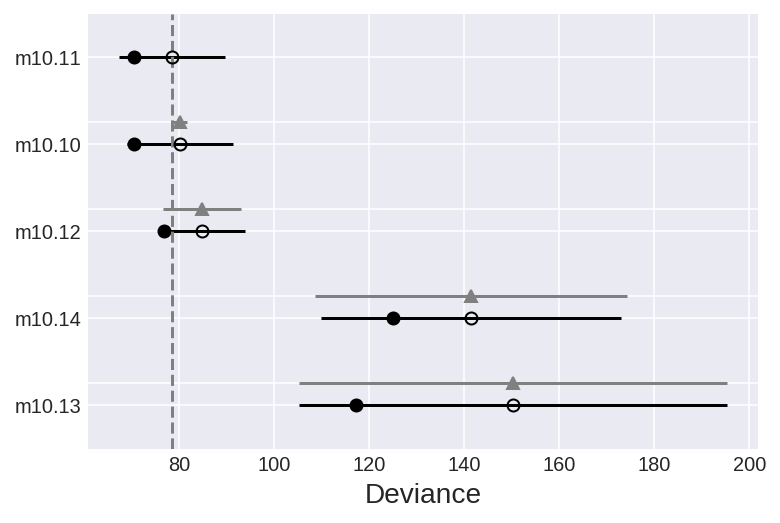

In [57]:
pm.compareplot(islands_compare);

#### Code 10.48

In [58]:
# set new value for out-of-sample prediction 
log_pop_seq = np.linspace(6, 13, 30)
log_pop.set_value(np.hstack([log_pop_seq, log_pop_seq]))
contact_high.set_value(np.hstack([np.repeat(0, 30), np.repeat(1, 30)]))
# our posterior predictive samples have 60 columns because we changed in the 
# tensor values above
islands_ensemble = pm.sample_ppc_w(traces, 10000, 
                                   models, weights=islands_compare.weight.sort_index(ascending=True))

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive_w()
  
100%|██████████| 10000/10000 [01:43<00:00, 96.45it/s]


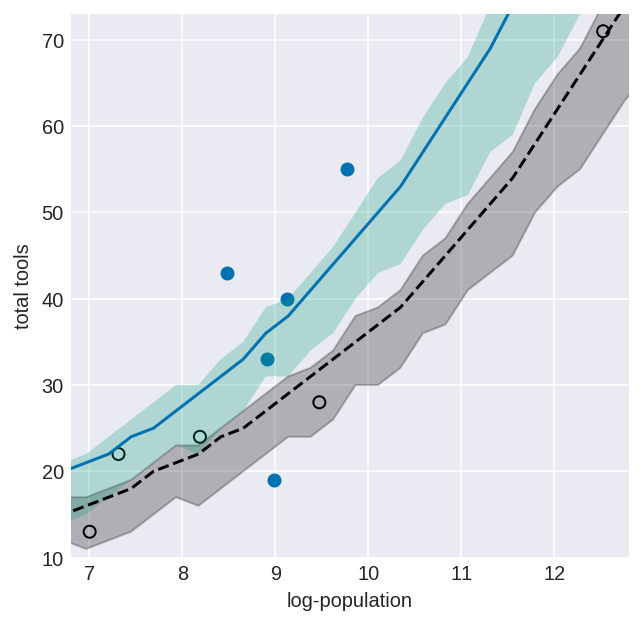

In [59]:
_, axes = plt.subplots(1, 1, figsize=(5, 5))
index = dk.contact_high==1
axes.scatter(np.log(dk.population)[~index], dk.total_tools[~index],
             facecolors='none', edgecolors='k', lw=1)
axes.scatter(np.log(dk.population)[index], dk.total_tools[index])

mp = islands_ensemble['total_tools'][:, :30]
mu_hpd = pm.hpd(mp, alpha=.50)

axes.plot(log_pop_seq, np.median(mp, axis=0), '--', color='k')
axes.fill_between(log_pop_seq,
                  mu_hpd[:,0], mu_hpd[:,1], alpha=0.25, color='k')

mp = islands_ensemble['total_tools'][:, 30:]
mu_hpd = pm.hpd(mp, alpha=.50)

axes.plot(log_pop_seq, np.median(mp, axis=0))
axes.fill_between(log_pop_seq,
                  mu_hpd[:,0], mu_hpd[:,1], alpha=0.25)
axes.set_xlabel('log-population')
axes.set_ylabel('total tools')
axes.set_xlim(6.8, 12.8)
axes.set_ylim(10, 73);

#### Code 10.49
This is the same as 10.41, but in the book using MCMC rather than MAP.

In [60]:
pm.summary(trace_10_10, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.95,0.36,0.01,0.36,1.52,842.17,1.0
b__0,0.26,0.03,0.00,0.21,0.32,839.41,1.0
b__1,-0.13,0.86,0.03,-1.42,1.24,811.80,1.0
b__2,0.05,0.09,0.00,-0.10,0.19,809.87,1.0


#### Code 10.50

In [61]:
log_pop_c = dk.log_pop.values - dk.log_pop.values.mean()
log_pop.set_value(log_pop_c)
contact_high.set_value(dk.contact_high.values)
total_tools.set_value(dk.total_tools.values)

with pm.Model() as m_10_10c:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1, shape=3)
    lam = pm.math.exp(a + b[0] * log_pop + b[1] * contact_high + b[2] * contact_high * log_pop)
    obs = pm.Poisson('total_tools', lam, observed=total_tools)
    trace_10_10c = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1034.81draws/s]


In [62]:
pm.summary(trace_10_10c, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,3.31,0.09,0.0,3.17,3.45,1039.27,1.0
b__0,0.26,0.04,0.0,0.21,0.32,1014.53,1.0
b__1,0.29,0.12,0.0,0.11,0.48,1114.75,1.0
b__2,0.06,0.17,0.0,-0.21,0.33,1504.41,1.0


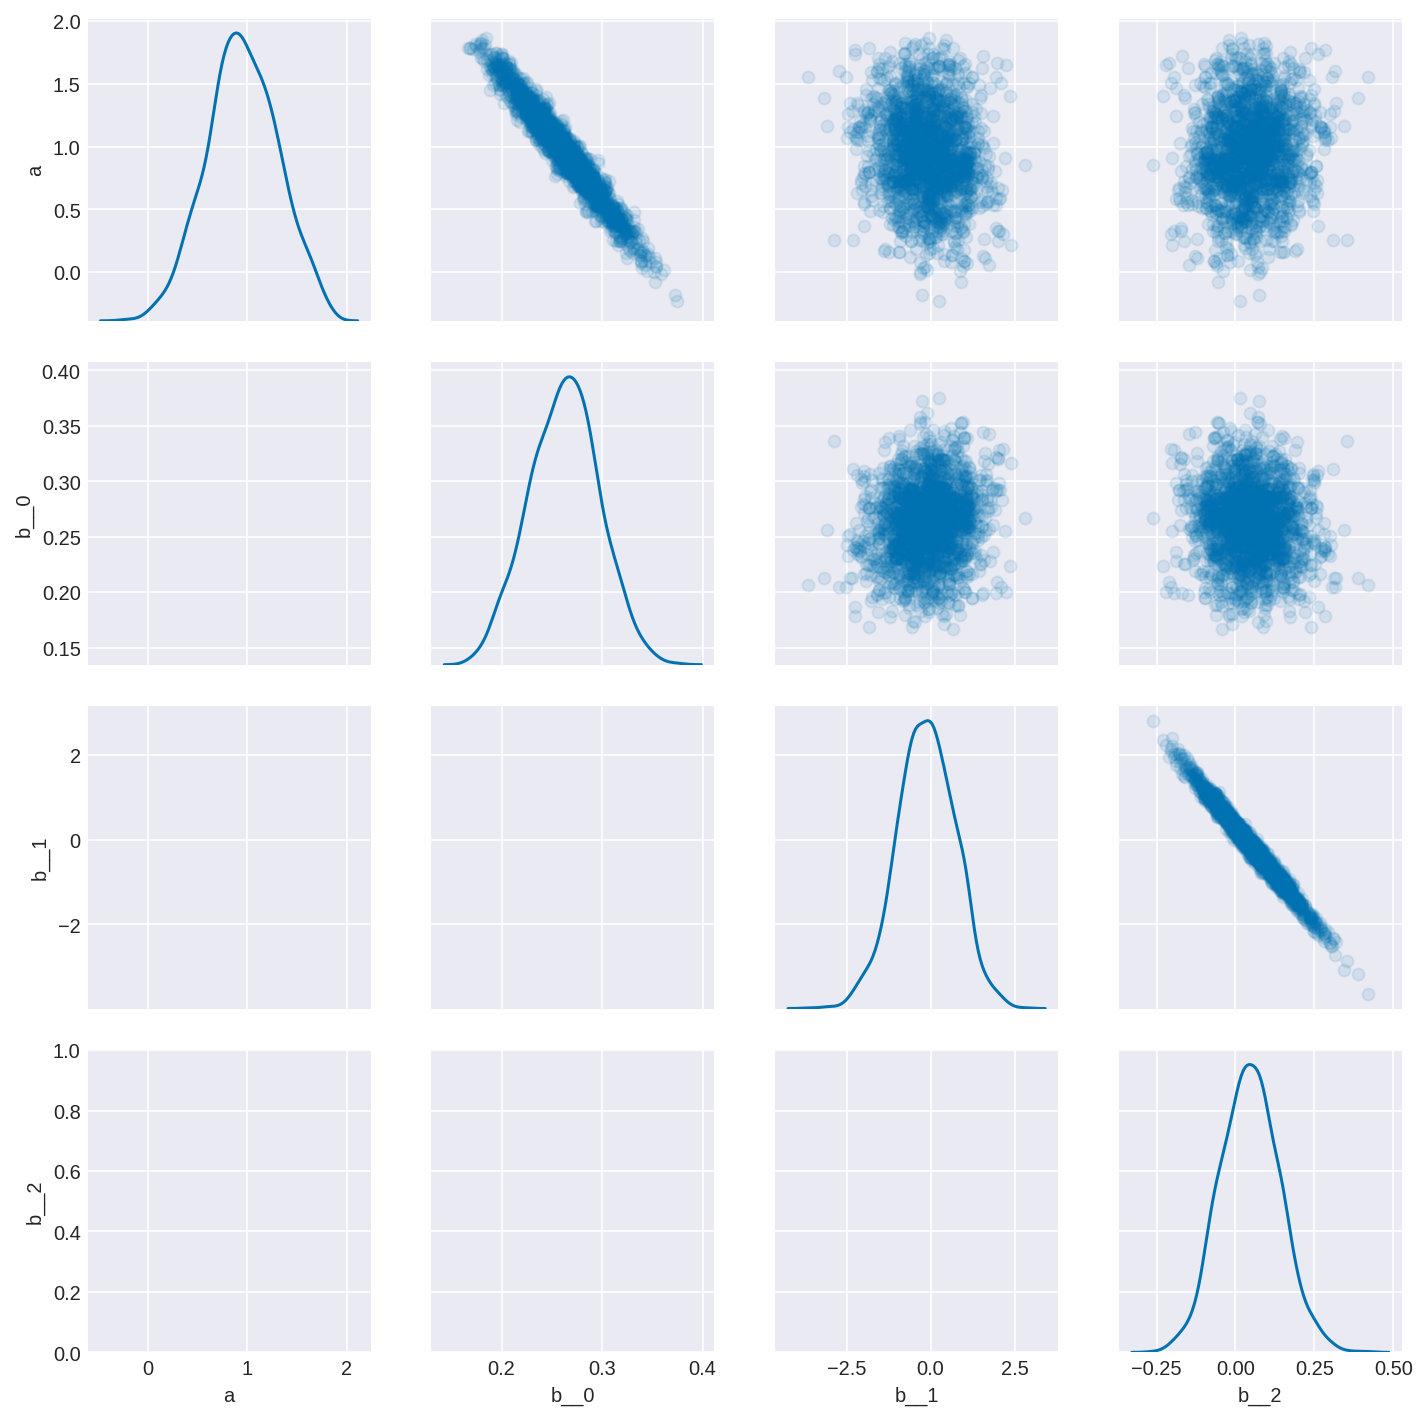

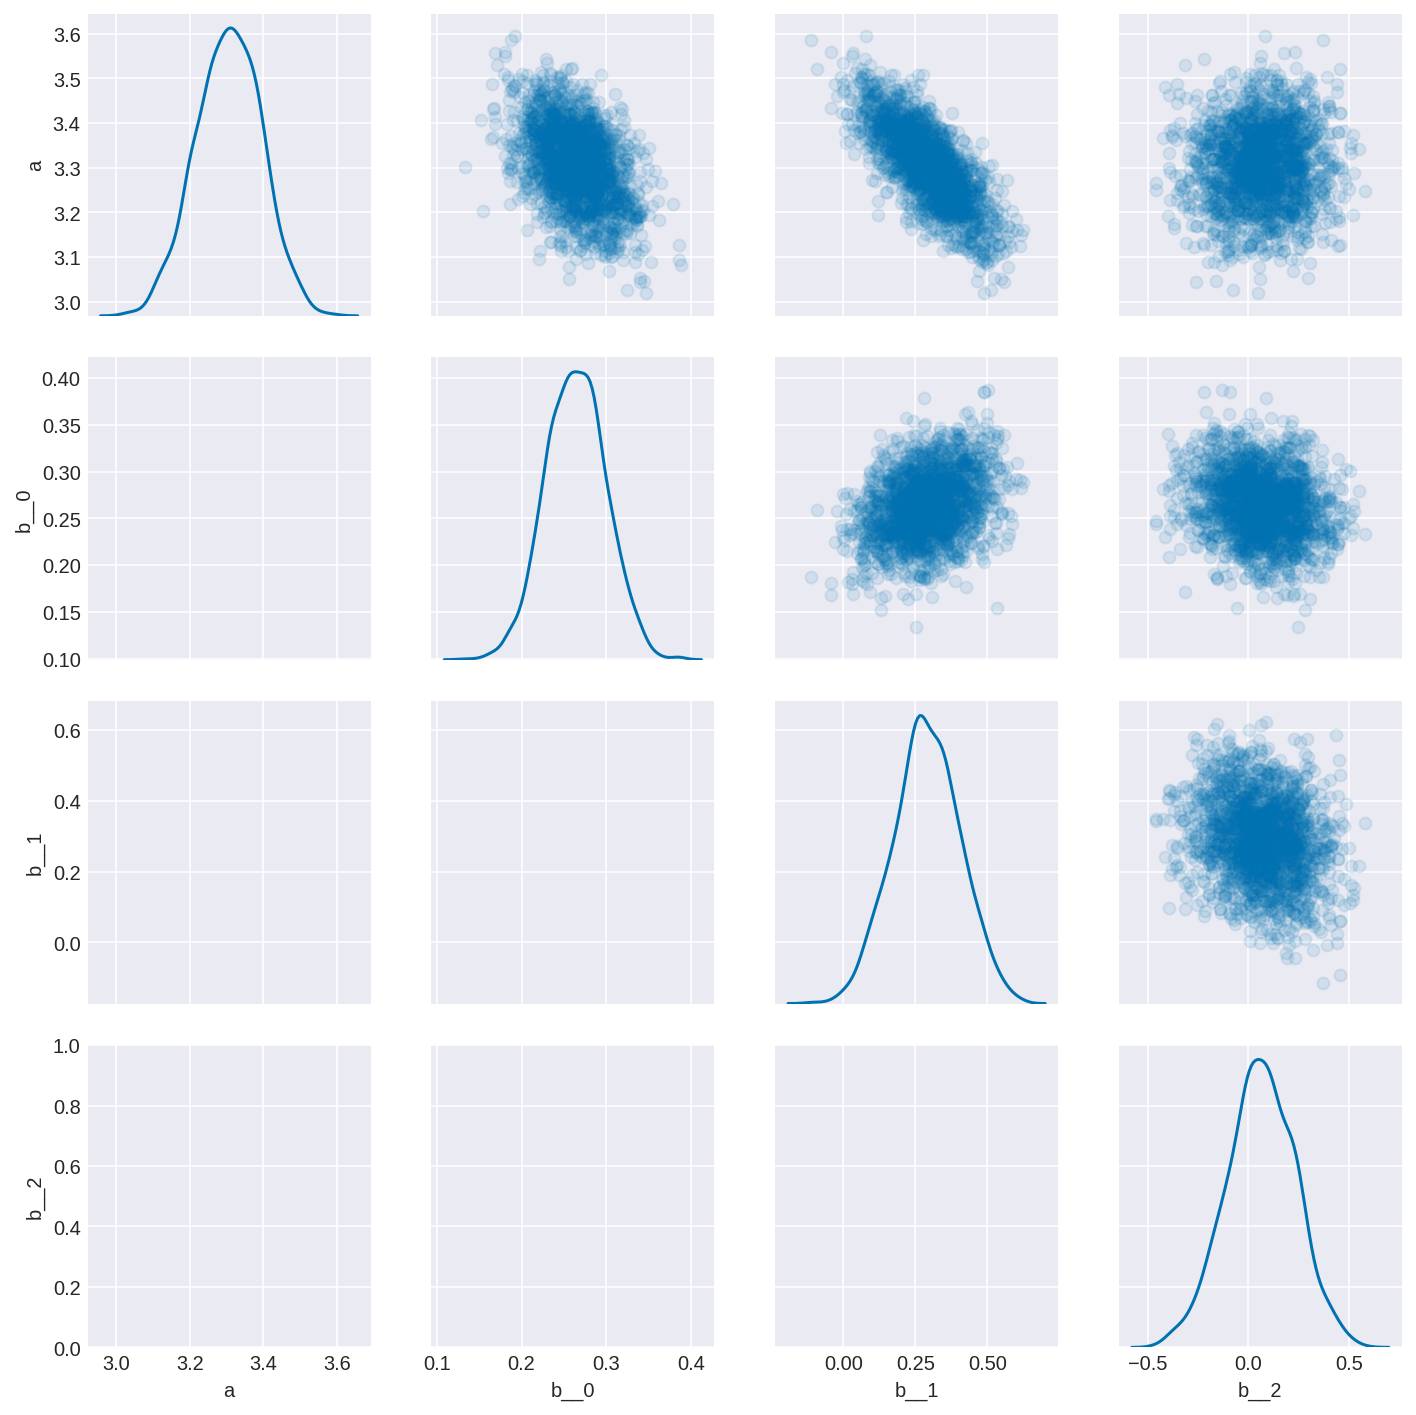

In [63]:
for trace in [trace_10_10, trace_10_10c]:
    tracedf = pm.trace_to_dataframe(trace)
    grid = (sns.PairGrid(tracedf,
                         diag_sharey=False)
               .map_diag(sns.kdeplot)
               .map_upper(plt.scatter, alpha=0.1))

#### Code 10.51

In [64]:
num_days = 30
y = np.random.poisson(1.5, num_days)

#### Code 10.52

In [65]:
num_weeks = 4
y_new = np.random.poisson(0.5*7, num_weeks)

#### Code 10.53

In [66]:
y_all = np.hstack([y, y_new])
exposure = np.hstack([np.repeat(1, 30), np.repeat(7, 4)]).astype('float')
monastery = np.hstack([np.repeat(0, 30), np.repeat(1, 4)])

In [67]:
exposure

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 7., 7., 7., 7.])

#### Code 10.54

In [68]:
log_days = np.log(exposure)
with pm.Model() as m_10_15:
    a = pm.Normal('a', 0., 100.)
    b = pm.Normal('b', 0., 1.)
    # offset by log of exposure
    lam = pm.math.exp(log_days + a + b*monastery)
    obs = pm.Poisson('y', lam, observed=y_all)
    trace_10_15 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1800.71draws/s]


#### Code 10.55

To compute the posterior distributions of λ in each monastery, we sample from the posterior and then just use the linear model, but without the offset now. We don’t use the offset again, when computing predictions, because the parameters are already on the daily scale, for both monasteries.

In [69]:
trace_10_15.add_values(dict(lambda_old=np.exp(trace_10_15['a']),
                            lambda_new=np.exp(trace_10_15['a'] + trace_10_15['b'])))

pm.summary(trace_10_15, varnames=['lambda_old', 'lambda_new'], alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
lambda_old,1.78,0.24,0.01,1.40,2.15,1659.49,1.0
lambda_new,0.31,0.10,0.00,0.15,0.45,1790.61,1.0


#### Code 10.56

In [70]:
# simulate career choices among 500 individuals
N = 500                 # number of individuals
income = np.arange(3)+1 # expected income of each career
score = 0.5*income      # scores for each career, based on income
# next line converts scores to probabilities
def softmax(w):
    e = np.exp(w)
    return e/np.sum(e, axis=0)

p = softmax(score)
# now simulate choice
# outcome career holds event type values, not counts
career = np.random.multinomial(1, p, size=N)
career = np.where(career==1)[1]

#### Code 10.57

In [71]:
import theano.tensor as tt
with pm.Model() as m_10_16:
    b = pm.Normal('b', 0., 5.)
    s2 = b*2
    s3 = b*3
    p_ = tt.stack([0, s2, s3])
    obs = pm.Categorical('career', p=tt.nnet.softmax(p_), observed=career)
    trace_10_16 = pm.sample(1000, tune=1000)
pm.summary(trace_10_16, alpha=.11).round(2)

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.
  import sys
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the futu

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
b,0.36,0.04,0.0,0.29,0.43,736.43,1.0


#### Code 10.58

In [72]:
N = 100
# simulate family incomes for each individual
family_income = np.random.rand(N)
# assign a unique coefficient for each type of event
b = np.arange(3)-1
# np.outer(b, family_income):
# multiply each value of family with b ([-1,0,1]) 
# this creates a metrix where each value of family_income is assigned to three values
# family_income = [0.2, 0.3] => np.outer(b, family_income) => [[-0.2,-0.3],[0,0], [0.2,0.3]] 
# the shape of the result is 3xn_family_income
# score[:, None] 
# we add a score [0.5, 1, 1.5] to each row of np.outer(b, family_income)
# to create an offset and then calculate softmax
# each row in p is a set of probabilities [p1, p2, p3] to be used in extracting random samples
# from the multinomial distribution
p = softmax(score[:, None] + np.outer(b, family_income)).T
# pp is a 1x3 row
career = np.asarray([np.random.multinomial(1, pp) for pp in p])
career = np.where(career==1)[1]

In [73]:
with pm.Model() as m_10_17:
    a23 = pm.Normal('a23', 0, 5, shape=2)
    b23 = pm.Normal('b23', 0, 5, shape=2)
    s2 = a23[0] + b23[0]*family_income
    s3 = a23[1] + b23[1]*family_income
    p_ = tt.stack([np.zeros(N), s2, s3]).T
    obs = pm.Categorical('career', p=tt.nnet.softmax(p_), observed=career)
    trace_10_17 = pm.sample(1000, tune=1000)
pm.summary(trace_10_17, alpha=.11).round(2)

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b23, a23]
Sampling 2 chains: 100%|

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a23__0,1.74,0.85,0.04,0.33,2.93,324.61,1.0
a23__1,1.77,0.83,0.04,0.48,2.97,295.19,1.0
b23__0,0.35,1.60,0.08,-2.05,2.99,343.50,1.0
b23__1,1.83,1.54,0.08,-0.45,4.33,323.26,1.0


so in this multinomial model if we want to make predictions of a new data point we get their scores as 
`s1=0, s2=a23__0+b23__0*family_income, s3=a23__1+b23__1*family_income` and then do a softmax `softmax(s1,s2,s3)` to get the probabilities the data point belonging to each category 

#### Code 10.59

In [74]:
d_ad = pd.read_csv('./Data/UCBadmit.csv', sep=';')

#### Code 10.60

In [75]:
# binomial model of overall admission probability
with pm.Model() as m_binom:
    a = pm.Normal('a', 0, 100)
    p = pm.math.invlogit(a)
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    trace_binom = pm.sample(1000, tune=1000)
    
# Poisson model of overall admission rate and rejection rate
with pm.Model() as m_pois:
    a = pm.Normal('a', 0, 100, shape=2)
    lam = pm.math.exp(a)
    admit = pm.Poisson('admit', lam[0], observed=d_ad.admit)
    rej = pm.Poisson('rej', lam[1], observed=d_ad.reject)
    trace_pois = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2218.81draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1322.08draws/s]


#### Code 10.61

In [76]:
m_binom = pm.summary(trace_binom, alpha=.11).round(2)
logistic(m_binom['mean'])

a    0.386986
Name: mean, dtype: float64

#### Code 10.62

In [77]:
m_pois = pm.summary(trace_pois, alpha=.11).round(2)
m_pois['mean'][0]
np.exp(m_pois['mean'][0])/(np.exp(m_pois['mean'][0])+np.exp(m_pois['mean'][1]))

0.38698582386066455

#### Code 10.63

In [78]:
# simulate
N = 100
x = np.random.rand(N)
y = np.random.geometric(logistic(-1 + 2*x), size=N)

with pm.Model() as m_10_18:
    a = pm.Normal('a', 0, 10)
    b = pm.Normal('b', 0, 1)
    p = pm.math.invlogit(a + b*x)
    obs = pm.Geometric('y', p=p, observed=y)
    trace_10_18 = pm.sample(1000, tune=1000)
pm.summary(trace_10_18, alpha=.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 968.43draws/s] 
The acceptance probability does not match the target. It is 0.7161669864175576, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-1.02,0.25,0.01,-1.43,-0.65,454.27,1.0
b,1.32,0.44,0.02,0.60,2.02,457.94,1.0


In [79]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.7.2
IPython 7.6.1
PyMC3 3.6
NumPy 1.16.0
Pandas 0.23.4
SciPy 1.2.0
Matplotlib 3.0.2



/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  
